In [4]:
import pandas as pd
import numpy as np
import gc
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn2, venn2_circles # requires pip install matplotlib_venn
import string
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk
from nltk.corpus import stopwords
import scipy
# import lightgbm as lgb

from utils import featurize_date_col

sns.set()
%matplotlib inline
pd.options.mode.chained_assignment = None

In [5]:
# user inputs:
LIMIT = None

In [6]:
train = pd.read_csv('data/train.csv', parse_dates=['activation_date'], infer_datetime_format=True, nrows=LIMIT)
train_active = pd.read_csv('data/train_active.csv', parse_dates=['activation_date'], infer_datetime_format=True, nrows=LIMIT)
test = pd.read_csv('data/test.csv', parse_dates=['activation_date'], infer_datetime_format=True, nrows=LIMIT)
test_active = pd.read_csv('data/test_active.csv', parse_dates=['activation_date'], infer_datetime_format=True, nrows=LIMIT)

In [7]:
print(len(train))
print(len(train['item_id'].unique()))
print(len(train['user_id'].unique()))

1503424
1503424
771769


In [8]:
train.description.isna().sum() / len(train)

0.07734079008982163

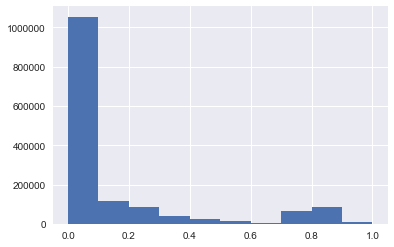

In [9]:
train.deal_probability.hist();

In [10]:
train.columns

Index(['item_id', 'user_id', 'region', 'city', 'parent_category_name',
       'category_name', 'param_1', 'param_2', 'param_3', 'title',
       'description', 'price', 'item_seq_number', 'activation_date',
       'user_type', 'image', 'image_top_1', 'deal_probability'],
      dtype='object')

In [11]:
# import seaborn as sns
# train = train[train['price']<1e6]
# sns.boxplot(x='parent_category_name', y='price', data=train)

In [12]:
all_samples = pd.concat([
    train,
    train_active,
    test,
    test_active
]).reset_index(drop=True)
all_samples.drop_duplicates(['item_id'], inplace=True) # here we assume each item was published only once?

del train_active
del test_active
gc.collect()

/Users/zexuanxu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  """


2675

In [13]:
# train_periods = pd.read_csv('data/periods_train.csv', parse_dates=['date_from', 'date_to', 'activation_date'], infer_datetime_format=True, nrows=LIMIT)
# test_periods = pd.read_csv('data/periods_test.csv', parse_dates=['date_from', 'date_to', 'activation_date'], infer_datetime_format=True, nrows=LIMIT)

In [14]:
# all_periods = pd.concat([
#     train_periods,
#     test_periods
# ])

# del train_periods
# del test_periods
# gc.collect()
# all_periods.columns

In [15]:
all_samples = all_samples.drop(['deal_probability', 'image', 'image_top_1'], axis=1)

In [16]:
all_samples['description'] = all_samples['description'].fillna('na')
all_samples['param_1'] = all_samples['param_1'].fillna('na')
all_samples['param_2'] = all_samples['param_2'].fillna('na')
all_samples['param_3'] = all_samples['param_3'].fillna('na')
all_samples['title'] = all_samples['title'].fillna('na')

In [17]:
all_samples = all_samples[~all_samples['category_name'].isna()]

In [18]:
mean_cat_price = all_samples[['price', 'category_name']].groupby('category_name')['price'].mean()
std_cat_price = all_samples[['price', 'category_name']].groupby('category_name')['price'].std()

In [19]:
null_price_idx = all_samples['price'].isna() # fillna with the normalized mean price of the category (i.e. 0.0)
all_samples['price'] = all_samples['price'].fillna(0.0) 

In [20]:
all_samples['price_norm'] = all_samples['price'].apply(np.log)
all_samples = all_samples.drop('price', axis=1)
all_samples['price_norm'][null_price_idx] = 0.0 # make sure there is no nan as we subtract the mean
for cat in all_samples['category_name'].unique():
    indexes = all_samples['category_name']==cat
    all_samples.loc[indexes, 'price_norm'] -= mean_cat_price[cat]
    all_samples.loc[indexes, 'price_norm'] /= std_cat_price[cat]
all_samples['price_norm'][null_price_idx] = 0.0

In [21]:
all_samples.loc[all_samples['item_seq_number'].isna(), 'item_seq_number'] = all_samples['item_seq_number'].median()

In [22]:
all_samples['user_type'] = all_samples['user_type'].fillna('Private') # most frquent user type (mode)

In [23]:
all_samples = all_samples.loc[~all_samples['activation_date'].isna(), :]

In [24]:
all_samples.isna().sum()/len(all_samples)* 100

activation_date         0.0
category_name           0.0
city                    0.0
description             0.0
item_id                 0.0
item_seq_number         0.0
param_1                 0.0
param_2                 0.0
param_3                 0.0
parent_category_name    0.0
region                  0.0
title                   0.0
user_id                 0.0
user_type               0.0
price_norm              0.0
dtype: float64

In [ ]:
all_samples.to_csv('data/all_samples_no_nulls.csv')

In [ ]:
# pd.value_counts(all_samples['activation_date'].dropna().astype(str)).plot(kind='bar')

In [ ]:
# all_samples.merge(all_periods, on=['item_id', 'activation_date'], how='left').dropna().head()

Here we should do the following:

1) for the remaining all data dropna (this will automatically exclude train/test data for which there is no date_to or date_from)

2) This train model should take in the train features and return days_online and days_to_publish (so two models really!)

3) Use the model trained in # 3 to predict date_from and date_to of user_ids that are not already included in periods_aggregate_featurize so we have a full dataset.

4) Now we have a fully featurized train that can be used to provide labels using ONLY periods related data


***** Actually a better idea might be to just use periods_aggregate results and train to predict some labels (dev can be a subset of train) and 1) look at the feature importances in predicting the deal_probability and then 2) train models to predict the most important features directly (rather than date_from and date_to) and 3) finally use those models to predict those important features for the user_ids that were NOT shared between the train and train_active datasets

In [ ]:
train.columns.values